## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction
 
The goal of this project is to understand the results of an A/B test run by an e-commerce website.
The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

Importing of libraries

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [3]:
%%HTML
<style type='text/css'>
.results{
font-size: 14px;
</style>

`1.` Data: `ab_data.csv`. Stored as  `df`.  

a. The top few rows here:

In [4]:
df=pd.read_csv('ab_data.csv')

In [5]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. the number of rows in the dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset

In [7]:
df.user_id.nunique()

290584

d. The proportion of users converted

In [8]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match

In [9]:
df.query('landing_page=="new_page" and group != "treatment"').count()[0] + df.query('landing_page=="old_page" and group != "control"').count()[0]

3893

f. Number of missing values

In [10]:
df.isnull().any().sum()

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. Therefore we need to drop these rows and store the data in df2. 

a.  **df2**

In [11]:
df_01=df.query('landing_page=="old_page" and group != "control"')
df_02=df.query('landing_page=="new_page" and group != "treatment"')
df2=df.drop(df_01.index, axis=0)
df2.drop(df_02.index, axis=0,inplace=True)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0


`3.` 

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

In [14]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [15]:
df2[df2.duplicated(subset='user_id', keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [16]:
df2[df2.duplicated(subset='user_id', keep='first')].index

Int64Index([2893], dtype='int64')

d. Dropping  **the last** of the rows with a duplicate **user_id**

In [17]:
df2.drop(df2[df2.duplicated(subset='user_id', keep='first')].index, axis=0, inplace=True)

`4.` 

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
p_old_df2=df2.query('group=="control"').converted.mean()
df2.query('group=="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
p_new_df2=df2.query('group=="treatment"').converted.mean()
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [22]:
len(df2.query('landing_page=="new_page"'))/len(df2.landing_page)

0.5000619442226688

e.

**Findings for the database "df2" values**
<ul>
<li><b>Overall conversion rate = 11.96%</b></li>
<li><b>Control group conversion rate to the new page = 12.04%**</b></li>
<li><b>Treatment group conversion rate to the old page = 11.89%</b></li>
</ul>
<b> Conversion rate for the new_page is slightly higher (0.15%)  than for a new page. This difference has no practical significance.</b>

<a id='ab_test'></a>
### Part II - A/B Test
 
##### Questions: 

1. Does the old page or the new page have the higher conversion rate?
2. Does the conversion rate depends on the country of user?
3. Is the conversion rate influenced by the daytime of the test?
4. Should the test run longer?

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?


`1.` The null hypothesis: $p_{new}$ and $p_{old}$ both have \"true\" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal
<center>
$H_{0}: p_{new} - p_{old} <= 0$ <br>
$H_{1}: p_{new} - p_{old} \gt 0$
</center>

Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page. 

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [24]:
num=(df2["converted"].mean()*len(df2["converted"])).astype(int)

In [25]:
num=np.count_nonzero(df2["converted"]==1)
num

34753

In [26]:
bootsample=df2.sample(num, replace=True)
p_new=bootsample.query('group=="treatment"').converted.mean()
p_new

0.11945061833931726

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [27]:
bootsample=df2.sample(num, replace=True)
p_old=bootsample.query('group=="control"').converted.mean()
p_old

0.12231414454785706

c. What is $n_{new}$, the number of individuals in the treatment group?

In [28]:
n_new=df2.query('group=="treatment"').user_id.count()
df2.query('group=="treatment"').user_id.count()


145310

d. What is $n_{old}$, the number of individuals in the control group?

In [29]:
n_old=df2.query('group=="control"').user_id.count()
df2.query('group=="control"').user_id.count()

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [30]:
new_page_converted=np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [31]:
old_page_converted=np.random.binomial(1, p_old, n_old)

g. 

In [32]:
obs_diff=new_page_converted.mean() -old_page_converted.mean()
obs_diff

print('Observation difference in the conversion rate between the old and new page based on the whole sample is {0:.4f}'.format(-obs_diff))

Observation difference in the conversion rate between the old and new page based on the whole sample is 0.0034


h. 10,000 $p_{new}$ - $p_{old}$ values using the np.random.choice as in parts (a) through (g) above

Assume that the conversion rate for new and old page is equal under the null and they are equal the converted rate in ab_data.csv regardless of the page. 

In [33]:
random.seed(42)
p_new = p_old = df2['converted'].mean()
p_new, p_old

(0.11959708724499628, 0.11959708724499628)

In [34]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  

Mean value of all diffs from the bootstraped samples:

In [35]:
np.mean(p_diffs)

3.0293797577455871e-06

Mean value from the whole sample

In [36]:
p_diff_df2=p_new_df2-p_old_df2
p_diff_df2

-0.0015782389853555567

This is the histogram of all sample proportion differencies between a new and the old page with the red vertical line showing the population conversion mean difference. The green line represents the mean of the sampling distribution.

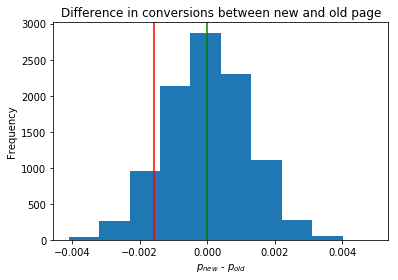

In [37]:
plt.hist(p_diffs)
plt.title('Difference in conversions between new and old page')
plt.xlabel('$p_{new}$ - $p_{old}$')
plt.ylabel('Frequency')
plt.axvline(x=p_diff_df2, color="red")
plt.axvline(x=np.mean(p_diffs), color="green")

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

Proportion of p_diffs which are bigger than the whole sample (df2) average: 

In [38]:
prob_more_extreme_high=(p_diffs>p_diff_df2).mean()
prob_more_extreme_high

0.9042

This \"right-side\" extreme is our p_value, since our alternative is $H_{1}: p_{new}-p_{old} \gt 0 $.

In [39]:
p_value=prob_more_extreme_high

k. Findings

**In this example is it showed the sampling distribution by the np.random.binomial under the null hypothesis $H_{0}: p_{new}-p_{old}\le 0$. Furthermore we  assume that the conversion rate for new and old page is equal under the null and they are equal the converted rate in ab_data.csv regardless of the page $p_{new}=p_{old}=p_{df2}$.**     

In [40]:
print("Since the p-value is {0:.4f}, we fail to reject the null hypothesis.".format(p_value))
print("It means that the new page has a lower conversion rate than the old page. It also means that we can be {0:.2f}% certain that the null hypothesis is correct.".format(p_value*100))

Since the p-value is 0.9042, we fail to reject the null hypothesis.
It means that the new page has a lower conversion rate than the old page. It also means that we can be 90.42% certain that the null hypothesis is correct.


l. We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

#### Statistical 2-sample model

In [41]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
convert_old = df2.query('group=="control" and converted==True').count()[0]
convert_new = df2.query('group=="treatment"and converted==True').count()[0]
n_old = n_old
n_new = n_new

In [42]:
count=[convert_old, convert_new]
nobs=[n_old,n_new]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

What is the p-value if $H_0: p_{new} \lt p_{old}$

In [45]:
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

What is the p-value if $H_0: p_{new} \gt p_{old}$

In [46]:
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative='larger')
z_score, p_value

(1.3109241984234394, 0.094941687240975514)

What is the p-value if $H_0: p_{old} = p_{new}$

In [47]:
stat, pval_ts = proportions_ztest(count, nobs, value=0, alternative="two-sided")

In [48]:
stat, pval_ts

(1.3109241984234394, 0.18988337448195103)

n. Findings

<p style="results">
<b>
   
   In the build-in statistical \"proportion z-test\" the resulting p-value  is 0.905 if the null $H_{0}: p_{new} \lt p_{old}$. It means we are 90.5\% certain that we cannot reject this null hypothesis. When we set up the null $H_{0}: p_{new} \gt p_{old}$ we get the complementary p_value 0.095.
<br><br>
In the alternative: \"two-sided\" we have tested if $p_{new}-p_{old}$ is significantly higher or lower than 0. The resulting p_value 0.1899 $\gt$ 0.05, so we fail to reject this hypothesis. We can see that the p_value for 2-sided hypothesis is twice 0.095.
<br><br>
The value of the z-score represents how many standard deviations the conversion rate is away from the mean. We have a z-score of 1.31, meaning the conversion rates in our distributions are between the 1st and 2nd standard deviations (the 1st STD contains ca. 68\% of all elements and the the 2nd contains STD ca. 95\% of all elements).
<br><br>
When we compare these results to the results from the sampling distribution (part j-k) we have obtained the same evidence, that the $H_{0}: p_{new} - p_{old} \le 0$ cannot be rejected. Furthermore, the \"proportion z-test\" shows high 
p_value (0.905) for $H_{0}: p_{new} \lt p_{old}$ - it suggests that actually the conversion rate for the old page is higher. 

</b>    
</p>

<a id='regression'></a>
### Part III - A regression approach

`1.` 
a. The type of regression

#### Logistic Regression

b. We will use the  **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a user receives. First need to be created a column in df2 for the intercept, a dummy variable column for which page each user received.  

In [49]:
df2['intercept']=1
df2['ab_page']=pd.get_dummies(df2['group'])['treatment']

In [50]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Instantiate the regression model on the two columns created in part b., then the model is fitted using the two columns created in part **b.** to predict whether or not an individual converts. 

In [51]:
lr=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=lr.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-16 12:01 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

d. Summary

In [52]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [53]:
1/np.exp(results.params.ab_page)

1.0151020136964732

e. Findings


<b>
<ul>
    <li>The p-value associated with the new page in the logistic regression is 0.1899. It is the same value as for the "two-sided" hypothesis in "the proportion z-test". The null hypothesis in both cases is $H_{0}: p_{new}-p_{old} = 0$ and we are testing if the $p_{new}-p_{old}$ is significantly higher or lower than 0.</li>
 <li>The difference between p-values from sampling distribution in Part 2 and logistic regression in Part 3 model is because we have performed a one-tailed test in Part 2 in sampling distribution, and in Part 3, we are performing a two-tailed test.</li>
 <li>
  If there is one less user from the treatment group, the conversion rate is likely 1.015 times higher as it was with this user holding all other coefficient constant.
 </li>
 <li>If there are zero users from the treatment group, then the conversion rate is 0.137.
    </li>
<li> From the above "Logistic Regression" results, we can see that the ab_page has the p_value > 0.05, therefore whether is it a new page or an old page is not statistically significant on the conversion rate. 
</li>    
</ul>
</b>

**Summary**


|Test               | NULL                       |   Alternative                      | p_value    |
| :-                |   :-                    |          :-                       |  :-       |
| sampling random.choice          | $$H_{0}: p_{new} - p_{old} \le 0$$ |$$H_{a}: p_{new} - p_{old} \gt 0$$     | 0.905   |
| proportional Z-test             | $$H_{0}: p_{new} - p_{old} \lt 0 $$| $$H_{a}: p_{new} - p_{old} \ge 0 $$  |  0.905  |
| proportional Z-test             | $$H_{0}: p_{new} - p_{old} \gt 0 $$|  $$H_{a}: p_{new} - p_{old} \le 0 $$ | 0.095   |
| proportional Z-test             | $$H_{0}: p_{new} - p_{old} = 0 $$  |  $$H_{a}: p_{old} - p_{new} \ne 0$$ |  0.189  |
 |Logistic Regression             | $$H_{0}: p_{new} - p_{old} = 0$$   |  $$H_{a}: p_{new} - p_{old} \ne 0$$ |  0.189  |


f. Why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<b>
<ul>
<li>It is good to consider other factors because sometimes other factors may correlate in a more clear way than the factor you are putting under the test, or maybe they are dependent on the factors under the test.</li>
<li>Interesting factors might be if an user see the page in a day or at night and how long time a user stays on the page. </li>
 <li>The main disandvantage is collinearity between predictors and therefore difficulties to interpret data. Is it wise to study 2-3 independent variables simultaneously.</li>
    
</b>    


g. Import **countries.csv** dataset and merge together with datasets on the appropriate rows. 
Does it appear that country had an impact on conversion? 

In [55]:
countries=pd.read_csv('countries.csv')
countries.country.unique()
countries.head()
df2_c=df2.join(countries.set_index('user_id'),on="user_id",how="inner")

In [56]:
df2_c.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [57]:
df2_c.groupby('country')['converted'].mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

In [58]:
df2_c.groupby('country')['converted'].count()

country
CA     14499
UK     72466
US    203619
Name: converted, dtype: int64

**Regarding the number of converted respondend, it appears that the highest conversion rate has the UK and the lowest converion rate has CA. The most of respondent are living in the US (70%) and the least in Canada (5%).**

In [59]:
df2_c[['US','UK','CA']]=pd.get_dummies(df2_c['country'])

h. We would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  



In [60]:
#df2_c=df2_c.drop('CA',axis=1)
df2_c.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [61]:
lr=sm.Logit(df2_c['converted'],df2_c[['intercept','ab_page','US','UK']])
results=lr.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-16 12:12 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [62]:
np.exp(results.params)

intercept    0.136795
ab_page      0.985168
US           0.960062
UK           1.009932
dtype: float64

In [63]:
lr=sm.Logit(df2_c['converted'],df2_c[['intercept','US','UK']])
results=lr.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-16 12:12 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
US           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [64]:
np.exp(results.params)

intercept    0.135779
US           0.960018
UK           1.009966
dtype: float64

In [65]:
1/np.exp(results.params.US)

1.0416468468924334

In [66]:
lr=sm.Logit(df2_c['converted'],df2_c[['intercept','US','CA']])
results=lr.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-16 12:12 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
US           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
CA           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
==================================================================

"""

In [67]:
np.exp(results.params)

intercept    0.137132
US           0.950546
CA           0.990133
dtype: float64

In [68]:
1/np.exp(results.params.CA)

1.0099656034853444

i. Findings <br><br>
<b>
The above coeffcients from the logistic regression shows us that there are practically not differences in conversion rate based on countries. 
<ul>

<li>The p-values are greater then >0.05, it means that all of the coefficients are not statistically significant on the conversion rate.</li>
<li>For an user from the UK, the conversion rate is likely to be 1.001 times higher than in CA holding all other coefficient constnat.</li> 
<li>For an user from the US, the conversion rate is likely to be 1.04 times lower than in CA holding all other coefficients constant.</li> 
<li>For an user from Canada, the conversion rate is likely to be 1.001 times lower then in the UK holding all other coefficients constant.</li>
</ul>   
</b>   

j. Now I will add the new columns with dummy varibles, which represent the new page for countries (if 1).

In [69]:
df2_c['UK_new'] = df2_c['UK'] * df2_c['ab_page']
df2_c['US_new'] = df2_c['US'] * df2_c['ab_page']

In [70]:
lr=sm.Logit(df2_c['converted'],df2_c[['intercept','ab_page','US_new','UK_new','US','UK']])
results=lr.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-16 12:12 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
US_new       -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_new        0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
US           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
==================================================================

"""

In [71]:
np.exp(results.params)

intercept    0.137178
ab_page      0.979646
US_new       0.954198
UK_new       1.031896
US           0.982625
UK           0.994272
dtype: float64

In [72]:
1/np.exp(results.params.US_new)

1.0480010229115175

k. Findings from the new table witch represents the new page for the countries.<br><br>
<b>
The above coeffcients from the logistic regression shows us that there are just a very small differences based on countries. 

<ul>

<li>The p-values are greater then >0.05, it means that any of the coefficient is not statistically significant on the conversion rate.</li>
<li>The user getting converted is 1.03 times more likely to happen for the UK and new page than for CA and the new page users while holding all other variable constant.</li>
<li>The user getting converted is 1.04 times less likely to happen for the US and new page users than for CA and the new page users while holding all other variable constant.</li>
</ul>
</b>

l. Show if **daytime** and **weekday** has an impact on converted rate

In [73]:
df2_c['timestamp']=pd.to_datetime(df2_c['timestamp'])

Weekend conversion rate base don the whole sample

In [74]:
df2_c[df2_c['timestamp'].dt.weekday > 4]['converted'].mean()

0.11964716525934861

The weekdays conversion rate

In [75]:
df2_c[df2_c['timestamp'].dt.weekday <= 4]['converted'].mean()

0.1195781990521327

The daytime conversion rate

In [76]:
df2_c[((df2_c['timestamp'].dt.hour< 22 ) & (df2_c['timestamp'].dt.hour >= 6)) ]['converted'].mean()

0.12056166434360642

In [77]:
df2_c.isnull().any().sum()

0

In [78]:
df2_c['hour']=df2_c['timestamp'].dt.hour

The night-time conversion rate

In [79]:
df2_c.query('hour < 6 or hour >= 22')['converted'].mean()

0.1176683114148275

How many days was running the test?

In [80]:
max(df2_c['timestamp']) - min(df2_c['timestamp'])

Timedelta('21 days 23:59:49.081927')

In [81]:
df2_c['day'] = df2_c['hour'].apply(lambda x :  1 if 6<=x<22  else 0)

In [82]:
df2_c['weekday']=df2_c['timestamp'].dt.weekday

In [83]:
df2_c['week'] = df2_c['weekday'].apply(lambda x :  1 if x>4  else 0)

In [84]:
df2_c.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,CA,UK_new,US_new,hour,day,weekday,week
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,22,0,5,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,8,1,3,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,16,1,2,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,18,1,6,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,1,0,5,1


In [85]:
df2_c.query('ab_page==1 and day==1').converted.mean()

0.12032419596303753

In [86]:
df2_c.query('ab_page==1 and day==0').converted.mean()

0.11577752553916004

In [87]:
df2_c.query('ab_page==0 and day==0').converted.mean()

0.11956050310828394

In [88]:
df2_c.query('ab_page==0 and day==1').converted.mean()

0.12079913272417532

In [89]:
#Create a new interaction variable between ab_page and day
df2_c['new_day']=df2_c['ab_page']*df2_c['day']


In [90]:
lr=sm.Logit(df2_c['converted'],df2_c[['intercept','ab_page','day']])
results=lr.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-05-16 12:13 AIC:              212777.2048
No. Observations:   290584           BIC:              212808.9437
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0072    0.0115  -174.8637  0.0000  -2.0297  -1.9847
ab_page      -0.0150    0.0114    -1.3105  0.1900  -0.0374   0.0074
day           0.0276    0.0122     2.2656  0.0235   0.0037   0.0514
==================================================================

"""

In [91]:
np.exp(results.params)

intercept    0.134361
ab_page      0.985127
day          1.027957
dtype: float64

m. Findings for daytime and weekdays involved <br><br>
<b>
 The logistic regression shows that day is slightly preferred for the conversion rate over night, and this coefficient is statistically significant (p_value 0.0235 $\lt$ 0.05). It shows that there is likely to be 1.02 higher conversion rate (0.023%), if there is a day and not the night. <br>
Althought the day is showed as statistically significant, the difference in the conversion rate is so small, that it has no pratical significance at all.
<br><br>
When I add a new coeffcient to the model - all converted during a day, any of the coefficient are statistically significant.   
</b>    

## Part IV - Logistic Regression with sklearn

a. Import of libraries:

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split 

np.random.seed(42)

In [93]:
X=df2_c[['day','new_day','ab_page']]
y=df2_c['converted']

In [94]:
X_train,X_test, y_train, y_test=train_test_split(X,y, test_size=0.2,random_state=0)

b. Initiate Logistic Regression:

In [95]:
log_mod=LogisticRegression()

c. Fit on train

In [96]:
log_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

d. Predict on test

In [97]:
preds=log_mod.predict(X_test)

e. Score

In [98]:
cm=confusion_matrix(y_test, preds)
cm

array([[51156,     0],
       [ 6961,     0]])

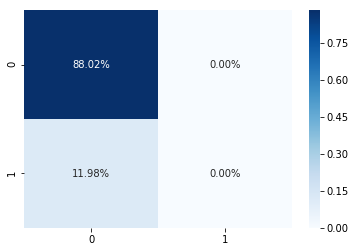

In [99]:
import seaborn as sns
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues');

f. Precision: The ability of the classifier not to label as positive a sample that is negative.

In [100]:
precision_score(y_test, preds)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

g. How good is our model?

In [101]:
accuracy_score(y_test, preds)

0.88022437496773753

In [102]:
recall_score(y_test, preds)

0.0

h. Findings <br></br>
<b>The count of true negatives is 51156 and false positives is 0,  false negatives is 6961  and true positive is 0. Therefore precision and recall is zero. Accuracy of our model is 88%, so we can believe this model. One can say the test has high specificity. The machine learning sklearn regression model shows that parametres are not significant for the converted rate.
</b>

## Part V - Additional part

Variance Inflation Factors (VIF) is a measure of colinearity among predictor variables within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone. Source: https://etav.github.io/python/vif_factor_python.html

a. VIFs coeffcients for predictors

In [185]:
df2_vif = df2_c._get_numeric_data() 

In [186]:
df2_vif.head()

,user_id,converted,intercept,ab_page,US,UK,CA,UK_new,US_new,hour,day,weekday,week,new_day,Day
0,851104,0,1,0,0,0,1,0,0,22,0,5,1,0,21
1,804228,0,1,0,0,0,1,0,0,8,1,3,0,0,12
2,661590,0,1,1,0,0,1,0,0,16,1,2,0,1,11
3,853541,0,1,1,0,0,1,0,0,18,1,6,1,1,8
4,864975,1,1,0,0,0,1,0,0,1,0,5,1,0,21


In [187]:
from patsy import dmatrices
features = df2_vif[['ab_page','day','week','new_day','US','UK','CA','UK_new','US_new','weekday','hour']].copy()
# get y and X dataframes based on this regression:
y, X = dmatrices( "converted ~ features", df2_vif, return_type='dataframe')

In [188]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [189]:
vif.round(1)

,VIF Factor,features
0,0.000000,Intercept
1,3.400000,features[0]
2,2.200000,features[1]
3,2.700000,features[2]
4,4.000000,features[3]
5,inf,features[4]
6,inf,features[5]
7,inf,features[6]
8,2.400000,features[7]
9,2.100000,features[8]


b. Days and the conversion rate

In [152]:
days=df2_c['timestamp'].dt.day.unique()
days_s=sorted(days)
#list(enumerate(days_s))

In [153]:
df2_c['timestamp'].dt.month.unique()

array([1])

In [154]:
count_days=[]
converted_rate=[]
for i in range (len(days)):
    count_days.append(df2_c[df2_c['timestamp'].dt.day == days_s[i]]['user_id'].count())
    converted_rate.append(df2_c[df2_c['timestamp'].dt.day == days_s[i]]['converted'].mean())
#converted_rate

Making matplotlib barplot showing conversion rates on day (in January 2017) with the number of users that day showing as a label above bars, source: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart

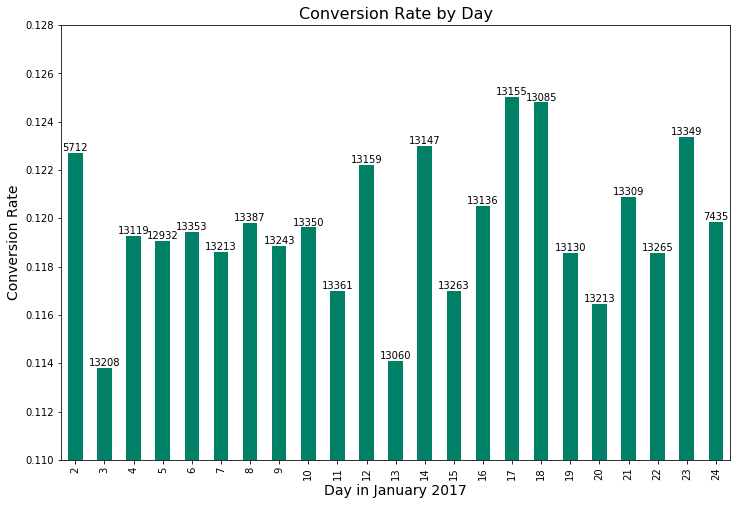

In [155]:
days_count = pd.Series(count_days)
conversion_rate=pd.Series(converted_rate)
##Colormap
import matplotlib.colors
# Plot the figure.
plt.figure(figsize=(12, 8))
ax = conversion_rate.plot(kind='bar', cmap='summer' )
ax.set_title('Conversion Rate by Day',size="16")
ax.set_xlabel('Day in January 2017', size="14")
ax.set_ylabel('Conversion Rate', size="14")
ax.set_xticklabels(days_s)
ax.set_ylim([0.110,0.128])
rects = ax.patches
def add_value_labels(ax):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    i=0
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = 0.001
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        
        ax.annotate(
        days_count[i],                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
         textcoords="offset points", # Interpret `xytext` as offset in points
         ha='center',                # Horizontally center label
         va=va)                      # Vertically align label differently for
                                        # positive and negative values.
        i=i+1

# Call the function above. All the magic happens there.
add_value_labels(ax)

In [156]:
df2_c['Day']=df2_c['timestamp'].dt.day

In [157]:
count_days_new=[]
converted_rate_new=[]
for i in range (len(days_s)):
    count_days_new.append(df2_c[(df2_c['Day'] == days_s[i]) & (df2_c['ab_page']==1)]['user_id'].count())
    converted_rate_new.append(df2_c[(df2_c['Day'] == days_s[i]) & (df2_c['ab_page']==1)]['converted'].mean())
#converted_rate_new

In [158]:
count_days_old=[]
converted_rate_old=[]
for i in range (len(days_s)):
    count_days_old.append(df2_c[(df2_c['Day'] == days_s[i]) & (df2_c['ab_page']==0)]['user_id'].count())
    converted_rate_old.append(df2_c[(df2_c['Day'] == days_s[i]) & (df2_c['ab_page']==0)]['converted'].mean())
#converted_rate_old    

In [159]:
converted_rate_new<converted_rate_old

True

<a id='conclusions'></a>
## Conclusion

**Overall, the conversion rate for the new_page is not bigger than for old page. Reffering to tested parametres like country and weektime and daytime, any of these have practical significance for the conversion rate. Since the number of users was high enough (>290584) and the test has run for almost 22 days, therefore is it wise to not to implement the new_page.**

In [190]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0